# Polynomial regression

## Train-test split

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('boston.csv')

In [2]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
def train_test_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [4]:
train_sample, test_sample = train_test_split(data, 0.2)

In [5]:
feature_size = data.shape[1]
train_size = train_sample.shape[0]
Y_train = train_sample['medv']
X_train = train_sample.drop(['medv'], axis = 1)

## Predictor filtering

### Correlation with the target variable

In [6]:
# I avoid using the internal corr function, of course...
def corr_pearson(X, Y):
    corr_pearson = []
    for j in range(X.shape[1]):
        X_temp = X.iloc[:, j] - np.mean(X.iloc[:, j])
        Y_temp = Y - np.mean(Y)
        R_temp = np.dot(X_temp, Y_temp) / np.sqrt(np.dot(X_temp, X_temp) * np.dot(Y_temp, Y_temp))
        corr_pearson.append(R_temp)
    return corr_pearson
    

In [7]:
corr_pearson(X_train, Y_train)

[-0.331782646421365,
 0.34232444638602477,
 -0.44379428912512137,
 0.1823570142004498,
 -0.3836836266470075,
 0.7003129406310663,
 -0.33969045122577773,
 0.19074356968768696,
 -0.3090916299532313,
 -0.4141125599231345,
 -0.5007277460031369,
 0.317093528597443,
 -0.7186536529838224]

In [8]:
absolute_values = [abs(number) for number in corr_pearson(X_train, Y_train)]

In [9]:
best_2_indices = np.argsort(absolute_values, axis=0)[-2:]

In [10]:
best_2_names = data.columns[best_2_indices]
best_2_names

Index(['rm', 'lstat'], dtype='object')

### Correlation matrix with all variables

In [11]:
import itertools as it

In [12]:
def corr_pearson_matrix(X):
    corr_pearson_matrix = np.ones((X.shape[1], X.shape[1]))
    for j, k in it.permutations(range(X.shape[1]), 2):
        X_j_temp = X.iloc[:, j] - np.mean(X.iloc[:, j])
        X_k_temp = X.iloc[:, k] - np.mean(X.iloc[:, k])
        R_temp = np.dot(X_j_temp, X_k_temp) / np.sqrt(np.dot(X_j_temp, X_j_temp) * np.dot(X_k_temp, X_k_temp))
        corr_pearson_matrix[j, k] = R_temp
    return corr_pearson_matrix

In [13]:
corr_train_matrix = corr_pearson_matrix(train_sample)

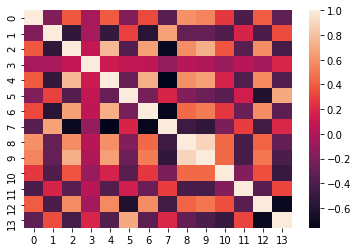

In [14]:
import seaborn as sns

corr_heatmap = sns.heatmap(corr_train_matrix)

Looking at the last column of the heatmap, we choose two that are either the darkest or the brightest--5 and 12. 

If we observe the rest, I would say that (8, 9) is suspected to be linearly dependent. 
Let me print out their values.

In [15]:
corr_train_matrix[8, 9]

0.8952652678012551

##  Multiple regression model based on X1 and X2

In [16]:
regressors_ind = best_2_names
explained_var_ind = "medv"

In [17]:
def feature_normalize(df, mu=None, sigma=None):
    # copy the dataframe
    if df.size == 0:
        return df, None, None
    df_normalized = df.copy()
    if mu is None and sigma is None:
        mu = df_normalized.mean(axis=0)
        sigma = df_normalized.std(axis=0, ddof=1)
    df_normalized = (df_normalized - mu) / sigma
    return df_normalized, mu, sigma

In [18]:
X = train_sample[regressors_ind]

X_norm = feature_normalize(X)[0]
mu = feature_normalize(X)[1]
sigma = feature_normalize(X)[2]

X_train = X_norm.copy()

n, d = X_train.shape
X_train.insert(0, "Ones", np.ones((n, 1)))


In [19]:
Y_train = pd.DataFrame(train_sample[explained_var_ind])


In [20]:
covXX = X_train.T.dot(X_train)
eigs_covXX = np.linalg.eig(covXX)[0]
cond_num_covXX = max(abs(eigs_covXX)) / min(abs(eigs_covXX))
display(eigs_covXX)
display(cond_num_covXX)

array([405.        , 652.74590249, 155.25409751])

4.204371497695609

In [21]:
beta_OLS_explicit_rm_lstat = np.linalg.inv(covXX).dot(X_train.T).dot(Y_train)
beta_OLS_explicit_rm_lstat

array([[23.08098765],
       [ 3.92926159],
       [-4.3808601 ]])

In [22]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_norm, Y_train)
beta_OLS_water_ca = regr.intercept_, regr.coef_
display(beta_OLS_water_ca)
display(Y_train.mean())

(array([23.08098765]), array([[ 3.92926159, -4.3808601 ]]))

medv    23.080988
dtype: float64

In [23]:
Y_hat_train = X_train.dot(beta_OLS_explicit_rm_lstat)

In [24]:
def loss_l2(Y_hat, Y):
    loss = np.mean(np.power(np.array(Y_hat) - np.array(Y), 2))
    return loss

In [25]:
loss_l2_train = loss_l2(Y_hat_train, Y_train)
loss_l2_train

33.62436793638125

In [26]:
X_test = test_sample[regressors_ind]

X_test_norm = feature_normalize(X_test, mu, sigma)[0]

X_test = X_test_norm.copy()
n, d = X_test.shape
X_test.insert(0, "Ones", np.ones((n, 1)))
X_test

Y_hat_test = X_test.dot(beta_OLS_explicit_rm_lstat)
Y_test= pd.DataFrame(test_sample[explained_var_ind])

loss_l2_test = loss_l2(Y_hat_test, Y_test)
loss_l2_test

18.51814260429716

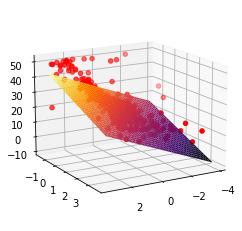

In [27]:
X1 = np.arange(min(X_train["rm"]), max(X_train["rm"]), 0.1)
X2 = np.arange(min(X_train["lstat"]), max(X_train["lstat"]), 0.1)
X1, X2 = np.meshgrid(X1, X2)
Z = beta_OLS_explicit_rm_lstat[0] + X1 * beta_OLS_explicit_rm_lstat[1] + X2 * beta_OLS_explicit_rm_lstat[2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_norm["rm"], X_norm["lstat"], Y_train, color='red')
ax.plot_surface(X1, X2, Z, cmap='inferno')
ax.view_init(15, 60)
plt.show()

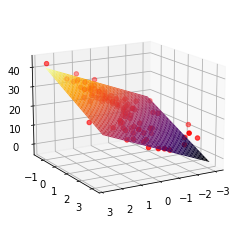

In [28]:
X1 = np.arange(min(X_test["rm"]), max(X_test["rm"]), 0.1)
X2 = np.arange(min(X_test["lstat"]), max(X_test["lstat"]), 0.1)
X1, X2 = np.meshgrid(X1, X2)
Z = beta_OLS_explicit_rm_lstat[0] + X1 * beta_OLS_explicit_rm_lstat[1] + X2 * beta_OLS_explicit_rm_lstat[2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test["rm"], X_test["lstat"], Y_test, color='red')
ax.plot_surface(X1, X2, Z, cmap='inferno')
ax.view_init(15, 60)
plt.show()

## Polynomial regression models based on X1 and X2 

In [29]:
X_train = train_sample[regressors_ind]
Y_train = train_sample["medv"]

In [30]:
X_test = test_sample[regressors_ind]
Y_test = test_sample["medv"]

In [31]:
def PolynomialFeatures(X_train, order):
    import itertools
    V_train = pd.DataFrame() 
    for index, row in X_train.iterrows():#遍历所有行
        row_values = row.tolist()
        row_poly_values = []
        for o in range(order):#遍历所有阶
            row_poly_values_of_this_degree = []
            for c in itertools.combinations_with_replacement(row_values, o+1): #当前次数下，排列组合所有形式
                result = 1
                for i in c: #列表内求积，eg: x1*x1, x1*x2
                    result = result * i  
                row_poly_values_of_this_degree.append(result)
            row_poly_values.extend(row_poly_values_of_this_degree)
        V_train_a_row = pd.DataFrame(row_poly_values).T
        V_train = V_train.append(V_train_a_row)
    n, d = V_train.shape
    V_train.index = range(n) #重建索引
    V_train.columns = np.array(range(d))+1
    V_train.insert(0, "Ones", np.ones((n, 1)))
    V_train.to_numpy()
    return V_train

In [32]:
class PolynomialRegression():
    def __init__(self):
        self.coefficients = None
        self.mu = None
        self.sigma = None
    
    def fit(self, X_train, Y_train, order):
        
        V_train = PolynomialFeatures(X_train, order+1)
        
        normalized, self.mu, self.sigma = feature_normalize(V_train.iloc[:,1:])
        V_train = np.c_[V_train.iloc[:,0], normalized]

        self.coefficients = np.linalg.pinv(V_train.T.dot(V_train)).dot(V_train.T.dot(Y_train))
        
        Y_train_hat = V_train.dot(self.coefficients).ravel()
        mse_train = (np.square(Y_train_hat - Y_train.ravel())).mean()

        return self
    
    def predict(self, X_test): 
        
        V_test = PolynomialFeatures(X_test, order+1) 

        normalized, _, _ = feature_normalize(V_test.iloc[:,1:], self.mu, self.sigma)
        V_test = np.c_[V_test.iloc[:,0], normalized]
        
        Y_test_hat = V_test.dot(self.coefficients)

        return Y_test_hat
    
    def score(self, X, Y):
        Y_hat = self.predict(X)
        return (np.square(Y_hat.ravel() - Y.ravel())).mean() #l2 loss function

In [129]:
k = 6
yh = np.zeros((len(X_train), k))
score = np.zeros((1, k)) 

for order in range(k):
    pr = PolynomialRegression().fit(X_train, Y_train, order)
    yh[:, order] = pr.predict(X_train).ravel()
    score[:, order] = pr.score(X_train, Y_train).ravel()

In [130]:
score#training loss 

array([[33.62436794, 22.32772952, 20.7326886 , 18.63571068, 16.66494789,
        15.90599189]])

In [136]:
# Coefficient estimates for order 2
pr = PolynomialRegression().fit(X_train, Y_train, 2)
theta = pr.coefficients
theta

array([[ 23.08098765],
       [-94.57114105],
       [-93.30448252],
       [169.56823807],
       [151.69056799],
       [ 26.81308553],
       [-69.96508902],
       [-71.18351466],
       [-17.5569722 ],
       [ -3.04961336]])

## Cross validation

In [35]:
X_train = train_sample[regressors_ind]
Y_train = train_sample["medv"]
X_test = test_sample[regressors_ind]
Y_test = test_sample["medv"]

In [36]:
import math

k = 6
n_train = X_train.shape[0]
n_test = X_test.shape[0]

#LOOCV
num_fold = n_train 
n_fold = math.floor(n_train / num_fold)

MSE_train_fold = np.zeros((k, num_fold))
CV_MSE_fold = np.zeros((k, num_fold))
MSE_train = np.zeros((k, 1))
CV_MSE = np.zeros((k, 1))
Y_test_hat = np.zeros((n_test, k))
MSE_test = np.zeros((k, 1))

for order in range(k): 
    Y_train_hat = np.zeros((n_train - n_fold, num_fold))
    Y_train_hat_fold = np.zeros((n_fold, num_fold))
    X_train_hat = []
    for cur_fold in range(num_fold):
        X_fold = X_train.iloc[cur_fold * n_fold:(cur_fold + 1) * n_fold]
        Y_fold = Y_train.iloc[cur_fold * n_fold:(cur_fold + 1) * n_fold]
        X_train_fold = X_train.iloc[np.r_[0:cur_fold * n_fold, (cur_fold + 1) * n_fold:n_train]] 
        Y_train_fold = Y_train.iloc[np.r_[0:cur_fold * n_fold, (cur_fold + 1) * n_fold:n_train]]
        
        pr = PolynomialRegression().fit(X_train_fold, Y_train_fold, order)
        MSE_train_fold[order, cur_fold] = pr.score(X_train_fold, Y_train_fold)
        CV_MSE_fold[order, cur_fold] = pr.score(X_fold, Y_fold)

    CV_MSE[order] = CV_MSE_fold[order,:].mean()
    MSE_train[order] = MSE_train_fold[order, :].mean()
    
    pr = PolynomialRegression().fit(X_train, Y_train, order)
    MSE_test[order] = pr.score(X_test, Y_test)

In [37]:
CV_MSE

array([[ 30.06767988],
       [ 21.73092542],
       [ 27.829155  ],
       [ 34.44111995],
       [269.09892735],
       [ 23.84276612]])

In [38]:
# Optimal degree of the polynomial
p_opt = np.argsort(CV_MSE, axis=0)[0]
p_opt

array([1], dtype=int64)

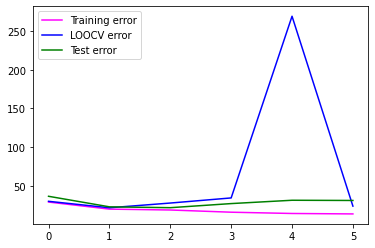

In [39]:
# Plots of the testing, CV, training errors
plt.plot(MSE_train, color="magenta")
plt.plot(CV_MSE, color="blue")
plt.plot(MSE_test, color='green')
plt.legend(('Training error','LOOCV error', 'Test error'))
plt.show()

None of the errors can be used as an estimate of statistical risk, because in a complete pipeline, we would need to use nested cross-validation for model selection and evaluation.

The optimal degree chosen by the training error is 8, but by the cross-validation and by the testing error is 2. We can see that the training error is always decreasing with a higher degree of the polynomial, which means that the more flexible the model, the better it is able to fit the data (including the noise inside). But when the model fits too closely with the noises, it doesn't generalize well on new data. Therefore one tends to overfit the model when fitting the model in-sample and it is useful to use cross-validation (or the testing sample if we have it) to select the optimal degree of the polynomial.

In [40]:
MSE_train[p_opt]

array([[19.97546633]])

In [41]:
MSE_test[p_opt]

array([[22.94152662]])

Comparing the training error and the testing error from a model of 2 degrees with the training error and testing error in the linear model in part 3, we can see that the error is much lower with the polynomial model. But this is normal since our data generating process is not linear.

# Other methods

## Gradient descent with l2 loss

In [72]:
class PolynomialRegressionGD_l2():
    def __init__(self):
        self.coefficients = None
        self.mu = None
        self.sigma = None
    
    def fit(self, X_train, Y_train, order, eta, n_iterations):
        n_train = X_train.shape[0]
        V_train = PolynomialFeatures(X_train, order+1)
        
        normalized, self.mu, self.sigma = feature_normalize(V_train.iloc[:,1:])
        V_train = np.c_[V_train.iloc[:,0], normalized]

        theta = np.random.randn(V_train.shape[1], 1)
        gradients = np.zeros((V_train.shape[1], 1))
        Y_train = np.array(Y_train).reshape(-1, 1)
        
        for iteration in range(n_iterations):
            gradients = 2/n_train * V_train.T.dot(V_train.dot(theta) - Y_train)
            theta = theta - eta * gradients
            
        self.coefficients = theta
        
        Y_train_hat = (V_train.dot(self.coefficients)).ravel()
        mse_train = (np.square(Y_train_hat - Y_train.ravel())).mean()

        return self
    
    def predict(self, X_test): 
        
        V_test = PolynomialFeatures(X_test, order+1) 

        normalized, _, _ = feature_normalize(V_test.iloc[:,1:], self.mu, self.sigma)
        V_test = np.c_[V_test.iloc[:,0], normalized]
        
        Y_test_hat = V_test.dot(self.coefficients)

        return Y_test_hat
    
    def score(self, X, Y):
        Y_hat = self.predict(X)
        return (np.square(Y_hat.ravel() - Y.ravel())).mean() #l2 loss function

In [155]:
order = 2
eta = 0.1
n_iterations = 1000

pr = PolynomialRegressionGD_l2().fit(X_train, Y_train, order, eta, n_iterations)
yh = pr.predict(X_train).ravel()
score = pr.score(X_train, Y_train).ravel()
pr.coefficients

array([[23.08098765],
       [-3.23129788],
       [-0.03552333],
       [ 1.95490827],
       [-2.59678755],
       [ 3.34889314],
       [ 7.14211742],
       [-6.10396821],
       [ 4.38790223],
       [-3.20658407]])

In [156]:
score = pr.score(X_test, Y_test)
score

14.155200541195411

## Gradient descent with Huber loss

In [112]:
delta = 1.35 * np.std(Y_train)

In [113]:
class PolynomialRegressionGD_huber():
    def __init__(self):
        self.coefficients = None
        self.mu = None
        self.sigma = None
    
    def fit(self, X_train, Y_train, order, eta, n_iterations):
        
        V_train = PolynomialFeatures(X_train, order+1)
        
        normalized, self.mu, self.sigma = feature_normalize(V_train.iloc[:,1:])
        V_train = np.c_[V_train.iloc[:,0], normalized]

        theta = np.random.randn(V_train.shape[1], 1)
    
        for iteration in range(n_iterations):
            theta = theta.reshape(-1, 1)
            error_vector = (np.dot(V_train, theta) - Y_train).ravel()
            total_points = 0
            gradients = np.zeros((V_train.shape[1], ))
            for index, value in enumerate(error_vector):
                total_points += 1
                error = error_vector[index]
                if error <= delta:
                    gradient_temp = value * V_train[index, :]
                else: 
                    gradient_temp = delta * abs(V_train[index, :])
                gradients = np.add(gradients, gradient_temp.T)
            gradients = gradients / total_points
            theta = theta.ravel() - eta * gradients
            
        self.coefficients = theta
        
        Y_train_hat = V_train.dot(self.coefficients).ravel()
        mse_train = (np.square(Y_train_hat - Y_train.ravel())).mean()

        return self
    
    def predict(self, X_test): 
        
        V_test = PolynomialFeatures(X_test, order+1) 

        normalized, _, _ = feature_normalize(V_test.iloc[:,1:], self.mu, self.sigma)
        V_test = np.c_[V_test.iloc[:,0], normalized]
        
        Y_test_hat = V_test.dot(self.coefficients)

        return Y_test_hat
    
    def score(self, X, Y):
        Y_hat = self.predict(X)
        return (np.square(Y_hat.ravel() - Y.ravel())).mean() #l2 loss function

In [157]:
order = 2
eta = 0.1
n_iterations = 1000

pr = PolynomialRegressionGD_huber().fit(X_train, Y_train, order, eta, n_iterations)
yh = pr.predict(X_train).ravel()
score = pr.score(X_train, Y_train).ravel()
pr.coefficients

array([23.12317167, -3.41736429, -0.53513378,  1.13730047, -2.42525231,
        1.93230676,  7.97307034, -4.65919376,  2.60637079, -1.04069544])

In [158]:
score = pr.score(X_test, Y_test)
score

13.672281141940063

## Stochastic gradient descent with l2 loss

In [116]:
def learning_schedule(t):
        t0, t1 = 5, 50
        return t0 / (t + t1)

class PolynomialRegressionSGD_l2():
    def __init__(self):
        self.coefficients = None
        self.mu = None
        self.sigma = None
    
    def fit(self, X_train, Y_train, order, n_epochs):
        
        V_train = PolynomialFeatures(X_train, order+1)
        
        normalized, self.mu, self.sigma = feature_normalize(V_train.iloc[:,1:])
        V_train = np.c_[V_train.iloc[:,0], normalized]

        np.random.seed(42)
        
        theta = np.random.randn(V_train.shape[1], 1)
        
        for epoch in range(n_epochs):
            for i in range(n_train):
                random_index = np.random.randint(n_train)
                xi = V_train[random_index:random_index+1]
                yi = Y_train[random_index:random_index+1]
                gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
                eta = learning_schedule(epoch * n_train + i)
                theta = theta - eta * gradients
            
        self.coefficients = theta
        
        Y_train_hat = V_train.dot(self.coefficients).ravel()
        mse_train = (np.square(Y_train_hat - Y_train.ravel())).mean()

        return self
    
    def predict(self, X_test): 
        
        V_test = PolynomialFeatures(X_test, order+1) 

        normalized, _, _ = feature_normalize(V_test.iloc[:,1:], self.mu, self.sigma)
        V_test = np.c_[V_test.iloc[:,0], normalized]
        
        Y_test_hat = V_test.dot(self.coefficients)

        return Y_test_hat
    
    def score(self, X, Y):
        Y_hat = self.predict(X)
        return (np.square(Y_hat.ravel() - Y.ravel())).mean() #l2 loss function

In [159]:
order = 2
eta = 0.1
n_epochs = 50

pr = PolynomialRegressionSGD_l2().fit(X_train, Y_train, order, n_epochs)
yh = pr.predict(X_train).ravel()
score = pr.score(X_train, Y_train).ravel()
pr.coefficients

array([[23.07128375],
       [-0.52011989],
       [ 2.7529903 ],
       [ 2.98111116],
       [-2.17039123],
       [ 2.90850077],
       [ 4.30945957],
       [-6.46868593],
       [ 1.25816972],
       [-1.65318747]])

In [160]:
score = pr.score(X_test, Y_test)
score

13.735501130405469

## Stochastic gradient descent with Huber loss

In [119]:
class PolynomialRegressionSGD_huber():
    def __init__(self):
        self.coefficients = None
        self.mu = None
        self.sigma = None
    
    def fit(self, X_train, Y_train, order, n_epochs):
        
        V_train = PolynomialFeatures(X_train, order+1)
        
        normalized, self.mu, self.sigma = feature_normalize(V_train.iloc[:,1:])
        V_train = np.c_[V_train.iloc[:,0], normalized]

        np.random.seed(42)
        
        theta = np.random.randn(V_train.shape[1], 1)
        
        for epoch in range(n_epochs):
            for i in range(n_train):
                random_index = np.random.randint(n_train)
                xi = V_train[random_index:random_index+1]
                yi = Y_train[random_index:random_index+1]
                
                delta = 1.35
                theta = theta.reshape(-1, 1)
                error_vector = (np.dot(xi, theta) - yi).ravel()
                total_points = 0
                gradients = np.zeros((xi.shape[1], ))
                for index, value in enumerate(error_vector):
                    total_points += 1
                    error = error_vector[index]
                    if error <= delta:
                        gradient_temp = value * xi[index, :]
                    else: 
                        gradient_temp = delta * abs(xi[index, :])
                    gradients = np.add(gradients, gradient_temp.T)
                gradients = gradients / total_points
                eta = learning_schedule(epoch * n_train + i)
                theta = theta.ravel() - eta * gradients
            
        self.coefficients = theta
        
        Y_train_hat = V_train.dot(self.coefficients).ravel()
        mse_train = (np.square(Y_train_hat - Y_train.ravel())).mean()

        return self
    
    def predict(self, X_test): 
        
        V_test = PolynomialFeatures(X_test, order+1) 

        normalized, _, _ = feature_normalize(V_test.iloc[:,1:], self.mu, self.sigma)
        V_test = np.c_[V_test.iloc[:,0], normalized]
        
        Y_test_hat = V_test.dot(self.coefficients)

        return Y_test_hat
    
    def score(self, X, Y):
        Y_hat = self.predict(X)
        return (np.square(Y_hat.ravel() - Y.ravel())).mean() #l2 loss function

In [161]:
order = 2
eta = 0.1
n_epochs = 50

pr = PolynomialRegressionSGD_huber().fit(X_train, Y_train, order, n_epochs)
yh = pr.predict(X_train).ravel()
score = pr.score(X_train, Y_train).ravel()
pr.coefficients

array([27.60693303, -3.46316041, -4.65593176,  0.82514807, -5.11387845,
        0.54911258,  3.65385411, -3.24096954,  0.89315445,  2.88902816])

In [162]:
score = pr.score(X_test, Y_test)
score

56.279813032720995